In [14]:
import glob  # glob module provides a function for making file lists from directory wildcard searches
import os  # Imports the OS interface module

# For data wrangling
import pandas as pd
import numpy as np

from scipy import interpolate

import datetime as dt

# FOr visualising the data
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.decomposition import PCA

from sklearn import preprocessing

from sklearn.ensemble import IsolationForest
import pickle 

# from sklearn.externals.joblib import dump, load
from pickle import dump


In [2]:
data = pd.read_csv('fulldf_hourly.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104292 entries, 0 to 104291
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AssetID                104292 non-null  object 
 1   FullDate               104292 non-null  object 
 2   Date                   104292 non-null  object 
 3   Reading_Imp            104292 non-null  float64
 4   Time                   104292 non-null  object 
 5   tempC                  104292 non-null  int64  
 6   windspeedKmph          104292 non-null  int64  
 7   winddirDegree          104292 non-null  int64  
 8   precipMM               104292 non-null  float64
 9   humidity               104292 non-null  int64  
 10  visibility             104292 non-null  int64  
 11  pressure               104292 non-null  int64  
 12  cloudcover             104292 non-null  int64  
 13  HeatIndexC             104292 non-null  int64  
 14  DewPointC              104292 non-nu

In [3]:
# Dropping unnecessary columns
data2 = data[['AssetID','FullDate','Reading_Imp','tempC','precipMM','humidity','pressure','WindGustKmph','totalSnow_cm','24HrsCumRainfall',
              'winddirDegree', 'visibility', 'cloudcover', 'TempGt20nRain','SGFNTRain']].copy()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104292 entries, 0 to 104291
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AssetID           104292 non-null  object 
 1   FullDate          104292 non-null  object 
 2   Reading_Imp       104292 non-null  float64
 3   tempC             104292 non-null  int64  
 4   precipMM          104292 non-null  float64
 5   humidity          104292 non-null  int64  
 6   pressure          104292 non-null  int64  
 7   WindGustKmph      104292 non-null  int64  
 8   totalSnow_cm      104292 non-null  float64
 9   24HrsCumRainfall  104292 non-null  float64
 10  winddirDegree     104292 non-null  int64  
 11  visibility        104292 non-null  int64  
 12  cloudcover        104292 non-null  int64  
 13  TempGt20nRain     104292 non-null  int64  
 14  SGFNTRain         104292 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 11.9+ MB


In [4]:
#convert the data type of timestamp column to datatime format
data2['FullDate'] = pd.to_datetime(data2['FullDate'])
data2['FullDate'].dtypes

dtype('<M8[ns]')

In [5]:
# data2.head()

In [6]:
assets = data2['AssetID'].unique()
assets

array(['1E09474', '1E18034', '3E03007', '3E43383'], dtype=object)

In [7]:
# Group the data by asset
groups_by_asset = data2.groupby('AssetID')
# Check the groups in the dataframe
groups_by_asset.groups.keys()

dict_keys(['1E09474', '1E18034', '3E03007', '3E43383'])

In [8]:
groups_by_asset

In [9]:
data2.columns

Index(['AssetID', 'FullDate', 'Reading_Imp', 'tempC', 'precipMM', 'humidity',
       'pressure', 'WindGustKmph', 'totalSnow_cm', '24HrsCumRainfall',
       'winddirDegree', 'visibility', 'cloudcover', 'TempGt20nRain',
       'SGFNTRain'],
      dtype='object')

In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104292 entries, 0 to 104291
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   AssetID           104292 non-null  object        
 1   FullDate          104292 non-null  datetime64[ns]
 2   Reading_Imp       104292 non-null  float64       
 3   tempC             104292 non-null  int64         
 4   precipMM          104292 non-null  float64       
 5   humidity          104292 non-null  int64         
 6   pressure          104292 non-null  int64         
 7   WindGustKmph      104292 non-null  int64         
 8   totalSnow_cm      104292 non-null  float64       
 9   24HrsCumRainfall  104292 non-null  float64       
 10  winddirDegree     104292 non-null  int64         
 11  visibility        104292 non-null  int64         
 12  cloudcover        104292 non-null  int64         
 13  TempGt20nRain     104292 non-null  int64         
 14  SGFN

In [41]:
def iforest_model2(group, asset_name): 
    
#     trans = RobustScaler()
#     data = trans.fit_transform(data)
    
    scaler = RobustScaler()
    group1 = group[['Reading_Imp','tempC','precipMM','humidity','pressure','WindGustKmph','totalSnow_cm','24HrsCumRainfall',
                    'winddirDegree', 'visibility', 'cloudcover', 'TempGt20nRain','SGFNTRain']].copy()


    # # min_max_scaler = preprocessing.StandardScaler()
    data_scaled = scaler.fit_transform(group1)
#     print(data_scaled.columns)
    Y = pd.DataFrame(data_scaled)

    # train isolation forest 
#     outliers_fraction = 0.1
    model =  IsolationForest()
#                           max_features=10,
#                           max_samples=10,
#                           n_estimators=1000,
#                           n_jobs=-1)
    model.fit(Y.values)

    dump(scaler, open('{}_scaler.pkl'.format(asset_name), 'wb'))
    dump(model, open('{}_model.pkl'.format(asset_name), 'wb'))

#     # add the data to the main  
    group['anomaly'] = pd.Series(model.predict(Y.values), index=group.index)
        
#--Newly added section
    group['scores'] = pd.Series(model.decision_function(Y.values), index=group.index)

#     group['anomaly_score'] = pd.Series(model.predict(Y.values), index=group.index)

#For evaluating the model let's set a threshold as salary > 99999 is an outlier.
#     outliers_counter = len(df[df['salary'] > 99999])
#     accuracy = 100*list(group['anomaly_score']).count(-1)/(outliers_counter)
#     print("Accuracy of the model:", accuracy)
#--End of Newly added section
    
    return group


In [42]:
def plot_anomalies(group):
    # visualization
    # fig, ax = plt.subplots(figsize=(25, 20))
    fig, ax1 = plt.subplots(figsize=(25, 20))
#     fig.suptitle("Telemtry Readings and Rainfall", fontsize=16)
    ax2 = ax1.twinx()

    a = group.loc[group['anomaly'] == -1] #anomaly
    a = a.reset_index()
    group = group.reset_index()
    
    #Plot the asset readings in blue
    ax1.scatter(group['FullDate'], group['Reading_Imp'], color='blue', label="Normal Reading")
    ax1.set_title("Telemtry Readings and Rainfall")
    #Plot the outliers identified by the model, in red
    ax1.scatter(a['FullDate'], a['Reading_Imp'], color='red',label="Anomalies")
    # Set common labels
    ax1.set_ylabel('Telemetry Readings')
    ax2.set_ylabel('Rainfall in mm')
    
    #Plot rainfall feature values to observe the changes in identified anomalies with rainfall
    ax2.plot(group['FullDate'], group['precipMM'], color='lime', label="Rainfall in mm")
    ax1.legend()
    ax2.legend(loc=2)
    plt.show()

<ipython-input-41-44473f457000>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['anomaly'] = pd.Series(model.predict(Y.values), index=group.index)
<ipython-input-41-44473f457000>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['scores'] = pd.Series(model.decision_function(Y.values), index=group.index)


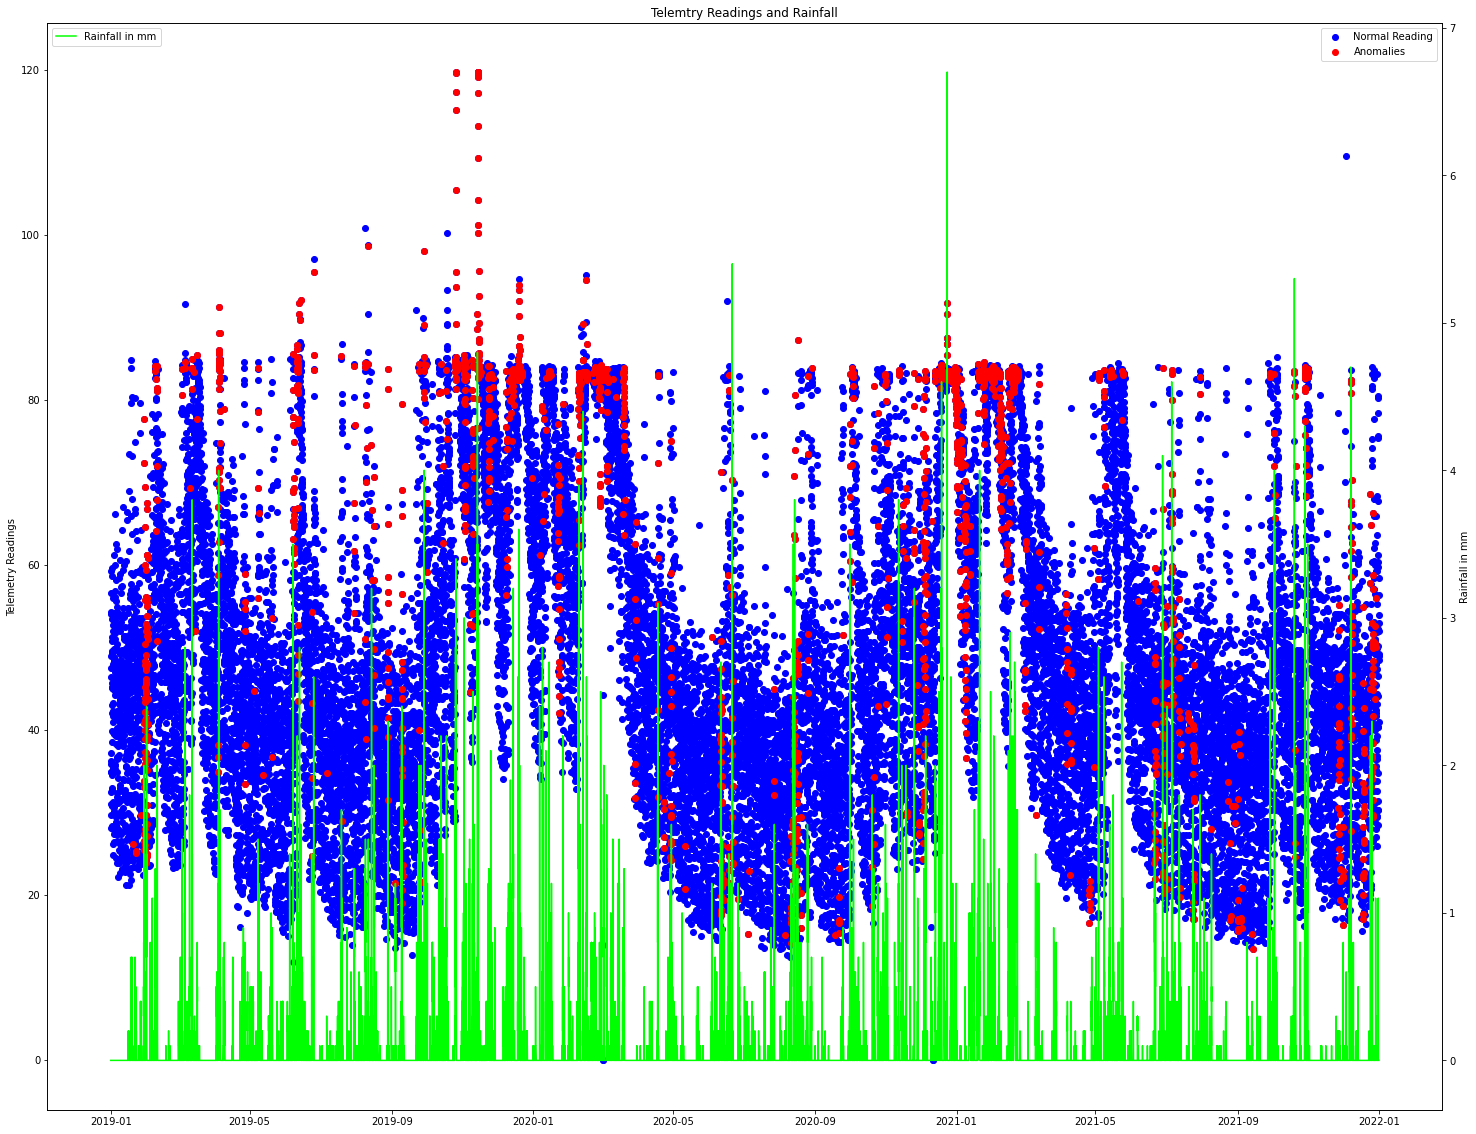

<ipython-input-41-44473f457000>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['anomaly'] = pd.Series(model.predict(Y.values), index=group.index)
<ipython-input-41-44473f457000>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['scores'] = pd.Series(model.decision_function(Y.values), index=group.index)


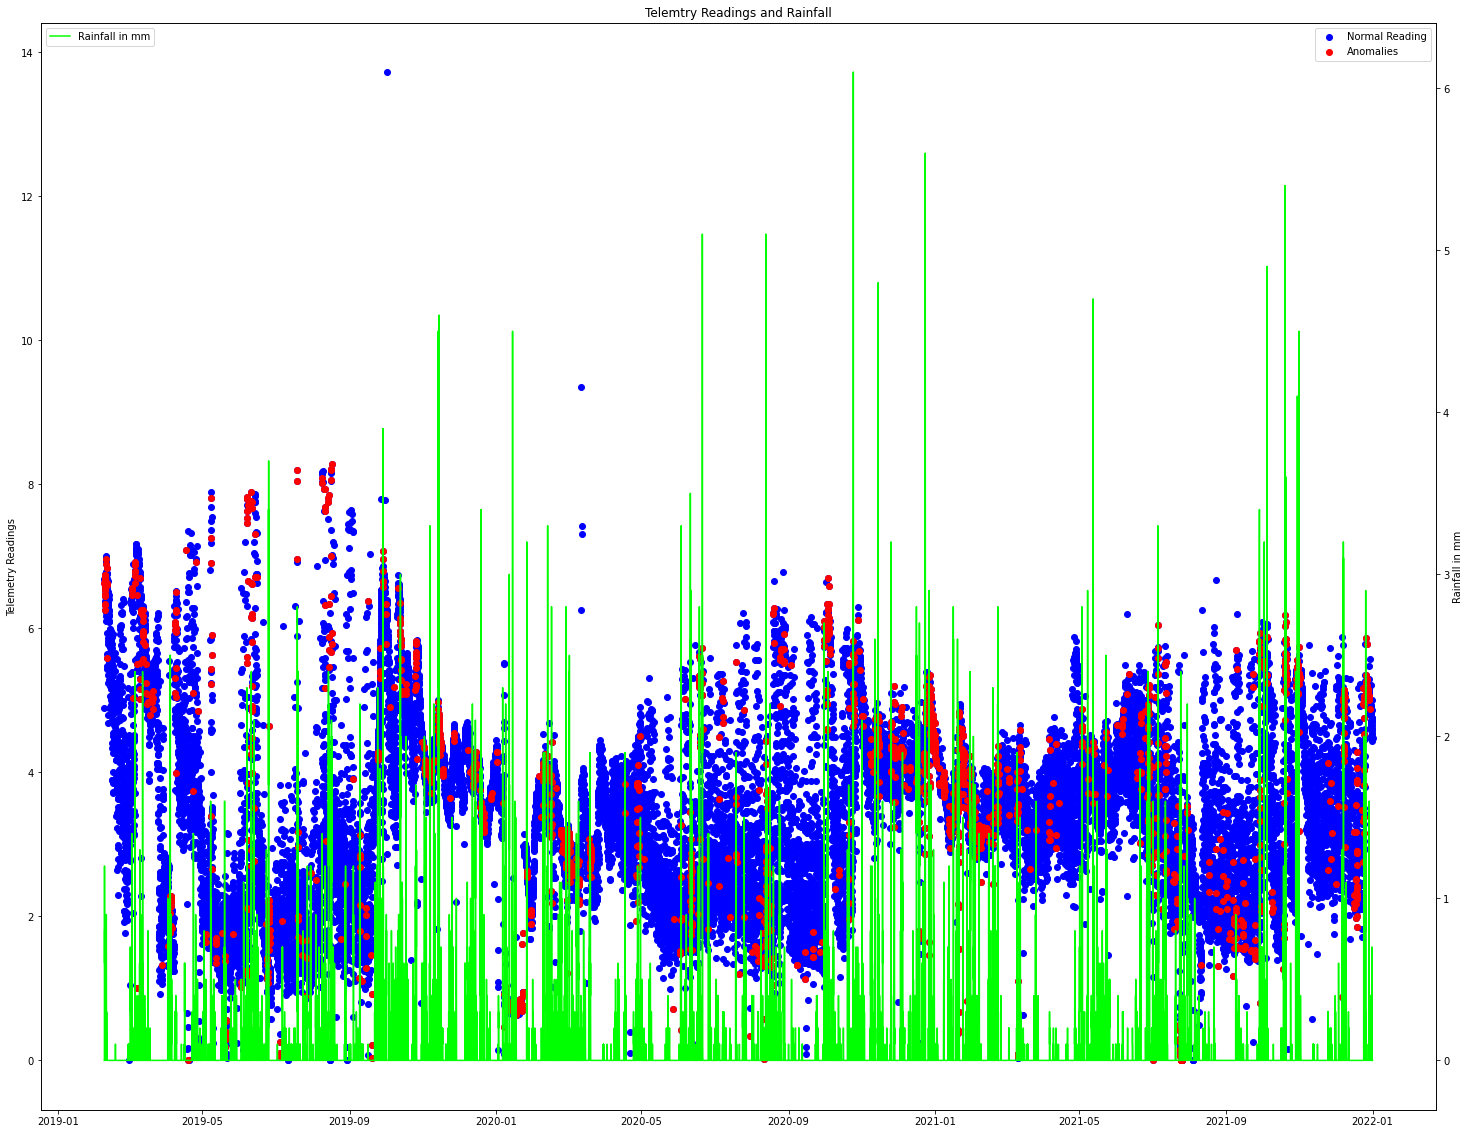

<ipython-input-41-44473f457000>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['anomaly'] = pd.Series(model.predict(Y.values), index=group.index)
<ipython-input-41-44473f457000>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['scores'] = pd.Series(model.decision_function(Y.values), index=group.index)


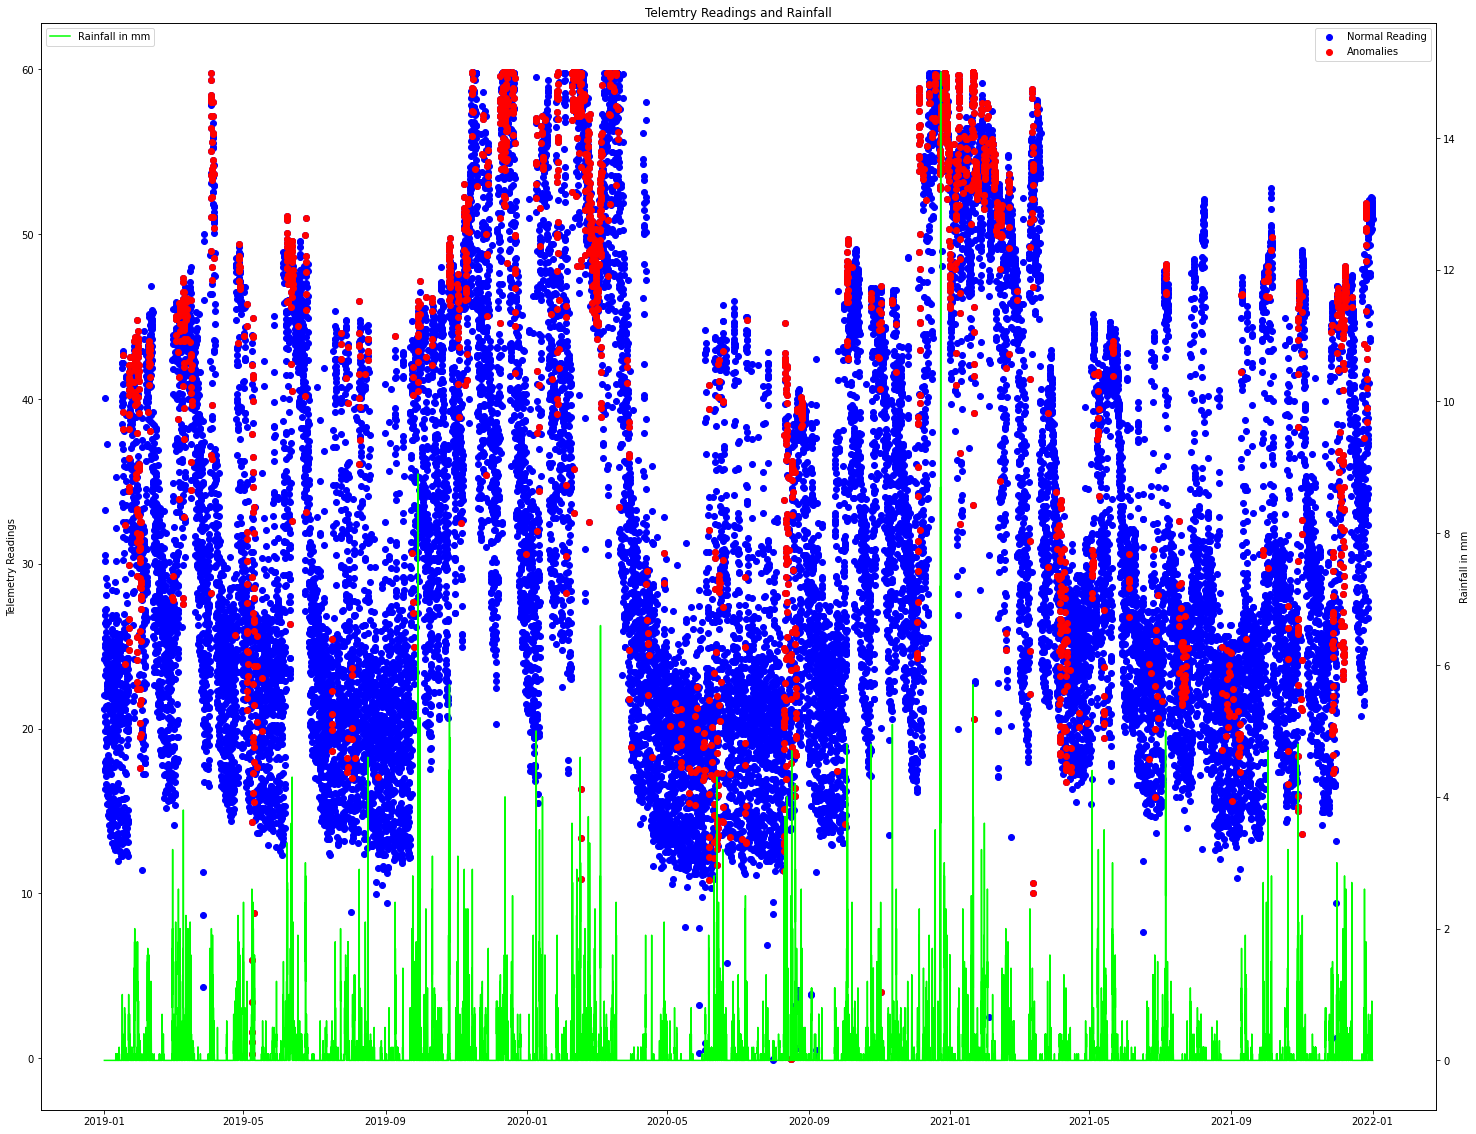

<ipython-input-41-44473f457000>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['anomaly'] = pd.Series(model.predict(Y.values), index=group.index)
<ipython-input-41-44473f457000>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['scores'] = pd.Series(model.decision_function(Y.values), index=group.index)


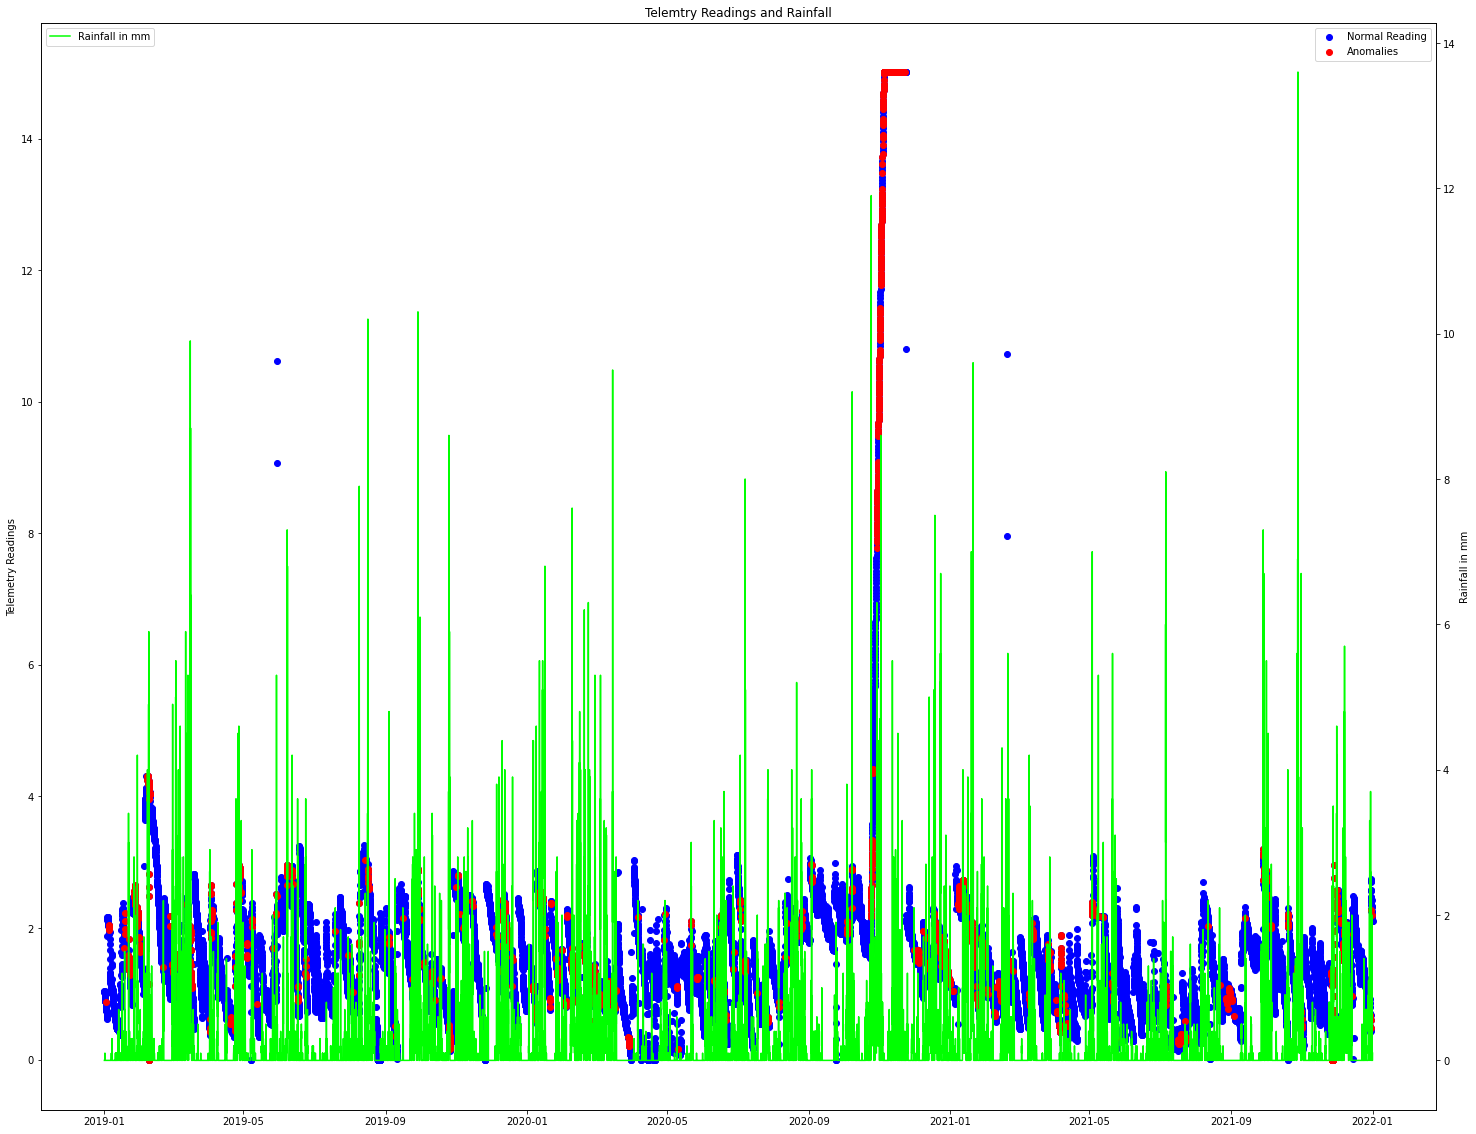

,AssetID,FullDate,Reading_Imp,tempC,precipMM,humidity,pressure,WindGustKmph,totalSnow_cm,24HrsCumRainfall,winddirDegree,visibility,cloudcover,TempGt20nRain,SGFNTRain,anomaly,scores
0,1E09474,2019-01-01 00:00:00,36.1550,5,0.0,93,1036,17,0.0,0.0,268,10,24,0,0,1,0.113581
1,1E09474,2019-01-01 01:00:00,35.8450,5,0.0,93,1036,18,0.0,0.0,271,10,24,0,0,1,0.112703
2,1E09474,2019-01-01 02:00:00,37.1800,5,0.0,93,1035,20,0.0,0.0,273,10,24,0,0,1,0.114339
3,1E09474,2019-01-01 03:00:00,29.7100,5,0.0,93,1035,22,0.0,0.0,276,10,24,0,0,1,0.107204
4,1E09474,2019-01-01 04:00:00,34.9025,5,0.0,93,1035,22,0.0,0.0,278,10,24,0,0,1,0.108479


In [43]:
#for every assetID's data, fitting the model seperately and plotting the anomalies identified by the model

# Create an empty dataframe
for_loop_forecast2 = pd.DataFrame()
# Loop through each ticker
for asset in assets:
    # Get the data for the ticker
    group = groups_by_asset.get_group(asset)  
    
    # Make forecast
    moutput = iforest_model2(group, asset)
    # Add the forecast results to the dataframe
    for_loop_forecast2 = pd.concat((for_loop_forecast2, moutput))
#     pred = detect_anomalies(group)
    plot_anomalies(moutput)
        
# print('The time used for the for-loop forecast is ', time()-start_time)
# Take a look at the data
for_loop_forecast2.head()

In [23]:
for_loop_forecast2.to_csv("iForestOutput_Allassets_noParam.csv", index=False)